<a href="https://colab.research.google.com/github/manansodha/stock-prediction-techniques/blob/main/Classification_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [ ]:
# Base Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
# ML Libs

# Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# Neural Networks (Tensorflow)
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Yahoo Finance Libs
import yfinance as yf

### Data Collection

In [ ]:
def get_data(symbol, start, end):
    """Get data from Yahoo Finance"""
    data = yf.download(symbol, start, end)
    date = pd.to_datetime(data.index).date
    return data, date

### Technical Indicators
*   SMA
*   EMA
*   RSI
*   MACD (Line, Signal, Hist)
*   Stochastic Oscillator
*   Boilinger Bands


In [ ]:
def rsi(data, days):
    delta = data['Adj Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=days).mean()
    avg_loss = loss.rolling(window=days).mean()

    rs = avg_gain / avg_loss
    rsi_val = 100 - (100 / (1 + rs))

    # rsi = rsi_val.apply(lambda x: 1 if x > 80 else (-1 if x < 20 else 0))
    return rsi_val

In [ ]:
def sma(data, days):
    sma = data['Adj Close'].rolling(window=days).mean()
    return sma

In [ ]:
def ema(data, days):
    ema = data['Adj Close'].ewm(span=days, adjust=False).mean()
    return ema

In [ ]:
def macd(data, long_window, short_window, signal_window):
    short_ema = data['Adj Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Adj Close'].ewm(span=long_window, adjust=False).mean()

    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

    histogram = macd_line - signal_line

    return macd_line, signal_line, histogram

In [ ]:
def stoch_osc(data, days):
    low_min = data['Low'].rolling(window=days).min()
    high_max = data['High'].rolling(window=days).max()
    range_val = high_max - low_min
    stoch_osc = (data['Adj Close'] - low_min) / range_val * 100
    return stoch_osc

In [ ]:
def boilinger_bands(data, days):
    sma = data['Adj Close'].rolling(window=days).mean()
    std = data['Adj Close'].rolling(window=days).std()

    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)

    return upper_band, lower_band

In [ ]:
def technical_indicators(data):
    df_technical = data
    df_technical['Open-Close'] = df_technical.Open - df_technical.Close
    df_technical['High-Low'] = df_technical.High - df_technical.Low
    df_technical['Returns'] = np.log((df_technical['Adj Close'] - df_technical['Adj Close'].shift(1)))

    # Technical Indicators
    day_lst = [10, 20, 50, 100, 200]
    for i in day_lst:
        df_technical['SMA_'+str(i)] = sma(df_technical, i)      # mention the window size(days) in dataframe column name
        df_technical['EMA_'+str(i)] = ema(df_technical, i)      # mention the window size(days) in dataframe column name

    df_technical['Volatility_10'] = df_technical['Adj Close'].rolling(window=10).std()      # mention the window size(days) in dataframe column name

    df_technical['OBV'] = (np.sign(df_technical['Adj Close'].diff()) * df_technical['Volume']).fillna(0).cumsum()

    df_technical['RSI_14'] = rsi(df_technical, 14)       # mention the window size(days) in dataframe column name

    macd_line, signal_line, histogram = macd(df_technical, 26, 12, 9)
    df_technical['MACD_Line'] = macd_line
    df_technical['MACD_Signal'] = signal_line
    df_technical['MACD_Histogram'] = histogram

    df_technical['Stochastic_Oscillator'] = stoch_osc(df_technical, 14)      # mention the window size(days) in dataframe column name

    df_technical['Upper_Band'], df_technical['Lower_Band'] = boilinger_bands(df_technical, 20)
    # Drop rows with missing values

    df_technical = df_technical.dropna()

    return df_technical

### Data Setting

In [ ]:
def target_data(data):
    df = technical_indicators(data)
    df['Target'] = df['Adj Close'] - df['Open']
    df['Target'] = df['Target'].shift(-1)

    df['TargetClass'] = np.where(df['Target'] > 0, 1, 0)
    df['TargetNextClose'] = df['Adj Close'].shift(-1)

    df.dropna(inplace=True)
    return df

### Feature Engineering
*   Correlation
*   Feature Selection
*   Input-Output Split




In [ ]:
def correlation_matrix(df):
    """Correlation Matrix"""
    corr = df.corr(method='pearson')
    plt.figure(figsize=(24, 16))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.show()
    return corr

In [ ]:
def feature_selection(df):
    """High Correlation Feature Selection"""
    corr = correlation_matrix(df)
    # threshold for correlation
    threshold = 0
    # Select features with high correlation to 'Close'
    high_corr_features = corr[abs(corr['TargetClass']) > threshold]['TargetClass'].index.tolist()
    high_corr_features.remove('TargetClass')
    high_corr_features.remove('Target')
    # high_corr_features.remove('TargetNextClose')

    return high_corr_features

In [ ]:
def input_output_split(df):
    """"Input-Output Set Split"""
    high_corr_features = feature_selection(df)
    a = df[high_corr_features]
    b = df['TargetClass']
    print(a.columns)
    # Initialize empty lists to store rolling window data
    a_data = []
    # Set the window size
    window_size = 30  # Example window size
    # Iterate through the data with a rolling window
    for i in range(window_size, len(df)):
        window_a = a.iloc[i - window_size:i]
        a_data.append(window_a)
    # Convert the lists to numpy arrays
    a = np.array([window.values.flatten() for window in a_data])
    b = np.array(b[window_size:])

    return a, b

### Machine Learning

In [ ]:
def ml_metrics(y_test, y_pred):
    """Machine Learning Metrics"""
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    return accuracy, precision, recall, f1, roc_auc

In [ ]:
def deep_learning(X_train, X_test, y_train, y_test):
    """Deep Learning"""
    layer1 = Dense(128, activation='relu')
    layer2 = Dense(32, activation='relu')
    layer3 = Dense(1, activation='relu')

    model = Sequential([layer1, layer2, layer3])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=10, batch_size=30, verbose=1)
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred > 0.5, 1, 0)

    return y_pred

In [ ]:
def machine_learning(X_train, X_test, y_train, y_test):
    """Machine Learning"""

    df_stats = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score'])
    df_predictions = pd.DataFrame()


    logistic_regression = LogisticRegression()
    knn = KNeighborsClassifier()
    naive_bayes = GaussianNB()
    decision_tree = DecisionTreeClassifier()
    random_forest = RandomForestClassifier()
    mlp = MLPClassifier()
    gradient_boost = GradientBoostingClassifier()

    # Train the models
    logistic_regression.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    naive_bayes.fit(X_train, y_train)
    decision_tree.fit(X_train, y_train)
    random_forest.fit(X_train, y_train)
    mlp.fit(X_train, y_train)
    gradient_boost.fit(X_train, y_train)

    # Predicting with the Models
    pred_lr = logistic_regression.predict(X_test)
    pred_knn = knn.predict(X_test)
    pred_nb = naive_bayes.predict(X_test)
    pred_dt = decision_tree.predict(X_test)
    pred_rf = random_forest.predict(X_test)
    pred_mlp = mlp.predict(X_test)
    pred_gb = gradient_boost.predict(X_test)
    pred_dl = deep_learning(X_train, X_test, y_train, y_test)

    # Create a DataFrame with the predictions
    df_predictions['Actual'] = y_test
    df_predictions['Logistic Regression'] = pred_lr
    df_predictions['KNN'] = pred_knn
    df_predictions['Naive Bayes'] = pred_nb
    df_predictions['Decision Tree'] = pred_dt
    df_predictions['Random Forest'] = pred_rf
    df_predictions['MLP'] = pred_mlp
    df_predictions['Gradient Boost'] = pred_gb
    df_predictions['Deep Learning'] = pred_dl

    # Shift the predictions by 1 day
    df_predictions['Logistic Regression'].shift(1)
    df_predictions['KNN'].shift(1)
    df_predictions['Naive Bayes'].shift(1)
    df_predictions['Decision Tree'].shift(1)
    df_predictions['Random Forest'].shift(1)
    df_predictions['MLP'].shift(1)
    df_predictions['Gradient Boost'].shift(1)
    df_predictions['Deep Learning'].shift(1)

    df_predictions.dropna(inplace=True)

    # Calculate the metrics
    for model in df_predictions.columns[1:]:
        accuracy, precision, recall, f1, roc_auc = ml_metrics(y_test, df_predictions[model])
        df_stats = pd.concat([df_stats, pd.DataFrame({'Model': model, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC AUC Score': roc_auc}, index=[0])], ignore_index=True)

    return df_stats, df_predictions

### Plotting

In [ ]:
def plot_predictions(df_predictions):
    """Plot the predictions"""
    fig = plt.figure(figsize=(20, 20))
    ax1 =  plt.subplot(421, xlabel='Date', ylabel='Price', title='Logistic Regression')
    ax2 =  plt.subplot(422, xlabel='Date', ylabel='Price', title='KNN')
    ax3 =  plt.subplot(423, xlabel='Date', ylabel='Price', title='Naive Bayes')
    ax4 =  plt.subplot(424, xlabel='Date', ylabel='Price', title='Decision Tree')
    ax5 =  plt.subplot(425, xlabel='Date', ylabel='Price', title='Random Forest')
    ax6 =  plt.subplot(426, xlabel='Date', ylabel='Price', title='MLP')
    ax7 =  plt.subplot(427, xlabel='Date', ylabel='Price', title='Gradient Boost')
    ax8 =  plt.subplot(428, xlabel='Date', ylabel='Price', title='Deep Learning')

    ax1.scatter(df_predictions.index, df_predictions['Actual'], label='Actual')
    ax1.scatter(df_predictions.index, df_predictions['Logistic Regression'], label='Logistic Regression')

    ax2.scatter(df_predictions.index, df_predictions['Actual'], label='Actual')
    ax2.scatter(df_predictions.index, df_predictions['KNN'], label='KNN')

    ax3.scatter(df_predictions.index, df_predictions['Actual'], label='Actual')
    ax3.scatter(df_predictions.index, df_predictions['Naive Bayes'], label='Naive Bayes')

    ax4.scatter(df_predictions.index, df_predictions['Actual'], label='Actual')
    ax4.scatter(df_predictions.index, df_predictions['Decision Tree'], label='Decision Tree')

    ax5.scatter(df_predictions.index, df_predictions['Actual'], label='Actual')
    ax5.scatter(df_predictions.index, df_predictions['Random Forest'], label='Random Forest')

    ax6.scatter(df_predictions.index, df_predictions['Actual'], label='Actual')
    ax6.scatter(df_predictions.index, df_predictions['MLP'], label='MLP')

    ax7.scatter(df_predictions.index, df_predictions['Actual'], label='Actual')
    ax7.scatter(df_predictions.index, df_predictions['Gradient Boost'], label='Gradient Boost')

    ax8.scatter(df_predictions.index, df_predictions['Actual'], label='Actual')
    ax8.scatter(df_predictions.index, df_predictions['Deep Learning'], label='Deep Learning')

    plt.legend()
    plt.show()

In [ ]:
def plot_metrics(df_stats):
    """Plot the metrics"""
    fig = plt.figure(figsize=(30, 10))
    ax1 = plt.subplot(321, title='Accuracy')
    ax2 = plt.subplot(322, title='Precision')
    ax3 = plt.subplot(323, title='Recall')
    ax4 = plt.subplot(324, title='F1 Score')
    ax5 = plt.subplot(325, title='ROC AUC Score')

    ax1.bar(df_stats['Model'], df_stats['Accuracy'])
    ax2.bar(df_stats['Model'], df_stats['Precision'])
    ax3.bar(df_stats['Model'], df_stats['Recall'])
    ax4.bar(df_stats['Model'], df_stats['F1 Score'])
    ax5.bar(df_stats['Model'], df_stats['ROC AUC Score'])

    plt.show()

In [ ]:
def plot_confusion_matrix(df_predictions):
    """Plot the confusion matrix"""
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
    models =['Logistic Regression', 'KNN', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'MLP', 'Gradient Boost', 'Deep Learning']

    for ax, model in zip(axes.flatten(), models):
        y_true = df_predictions['Actual']
        y_pred = df_predictions[model]
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax)
        ax.set_title(model)
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
    plt.show()

### Main Function

In [ ]:
def main(symbol, start, end):
    """Main function"""
    data, date = get_data(symbol, start, end) # Getting the data
    data_augment = target_data(data) # Data with TI and target Values
    data_augment = data_augment.drop(['Open', 'High', 'Low', 'Volume', 'Close', 'Adj Close', 'TargetNextClose'], axis=1)

    X, y = input_output_split(data_augment) # Input-Output Split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.25, random_state=42)
    X_train = np.nan_to_num(X_train, posinf=np.nan, neginf=np.nan) # Replace infinite values with NaN in training set
    X_test = np.nan_to_num(X_test, posinf=np.nan, neginf=np.nan) # Replace infinite values with NaN in test set

    X_train = pd.DataFrame(X_train).fillna(method='ffill').fillna(method='bfill').values # Fill NaN values using forward and backward fill in training set
    X_test = pd.DataFrame(X_test).fillna(method='ffill').fillna(method='bfill').values # Fill NaN values using forward and backward fill in test set
    df_stats, df_predictions = machine_learning(X_train, X_test, y_train, y_test)

    n = df_predictions.shape[0]
    df_predictions.index = date[n*-1:]
    # plot_predictions(df_predictions)
    plot_metrics(df_stats)
    plot_confusion_matrix(df_predictions)

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-38-8942e555a7fe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = df['Adj Close'] - df['Open']
<ipython-input-38-8942e555a7fe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

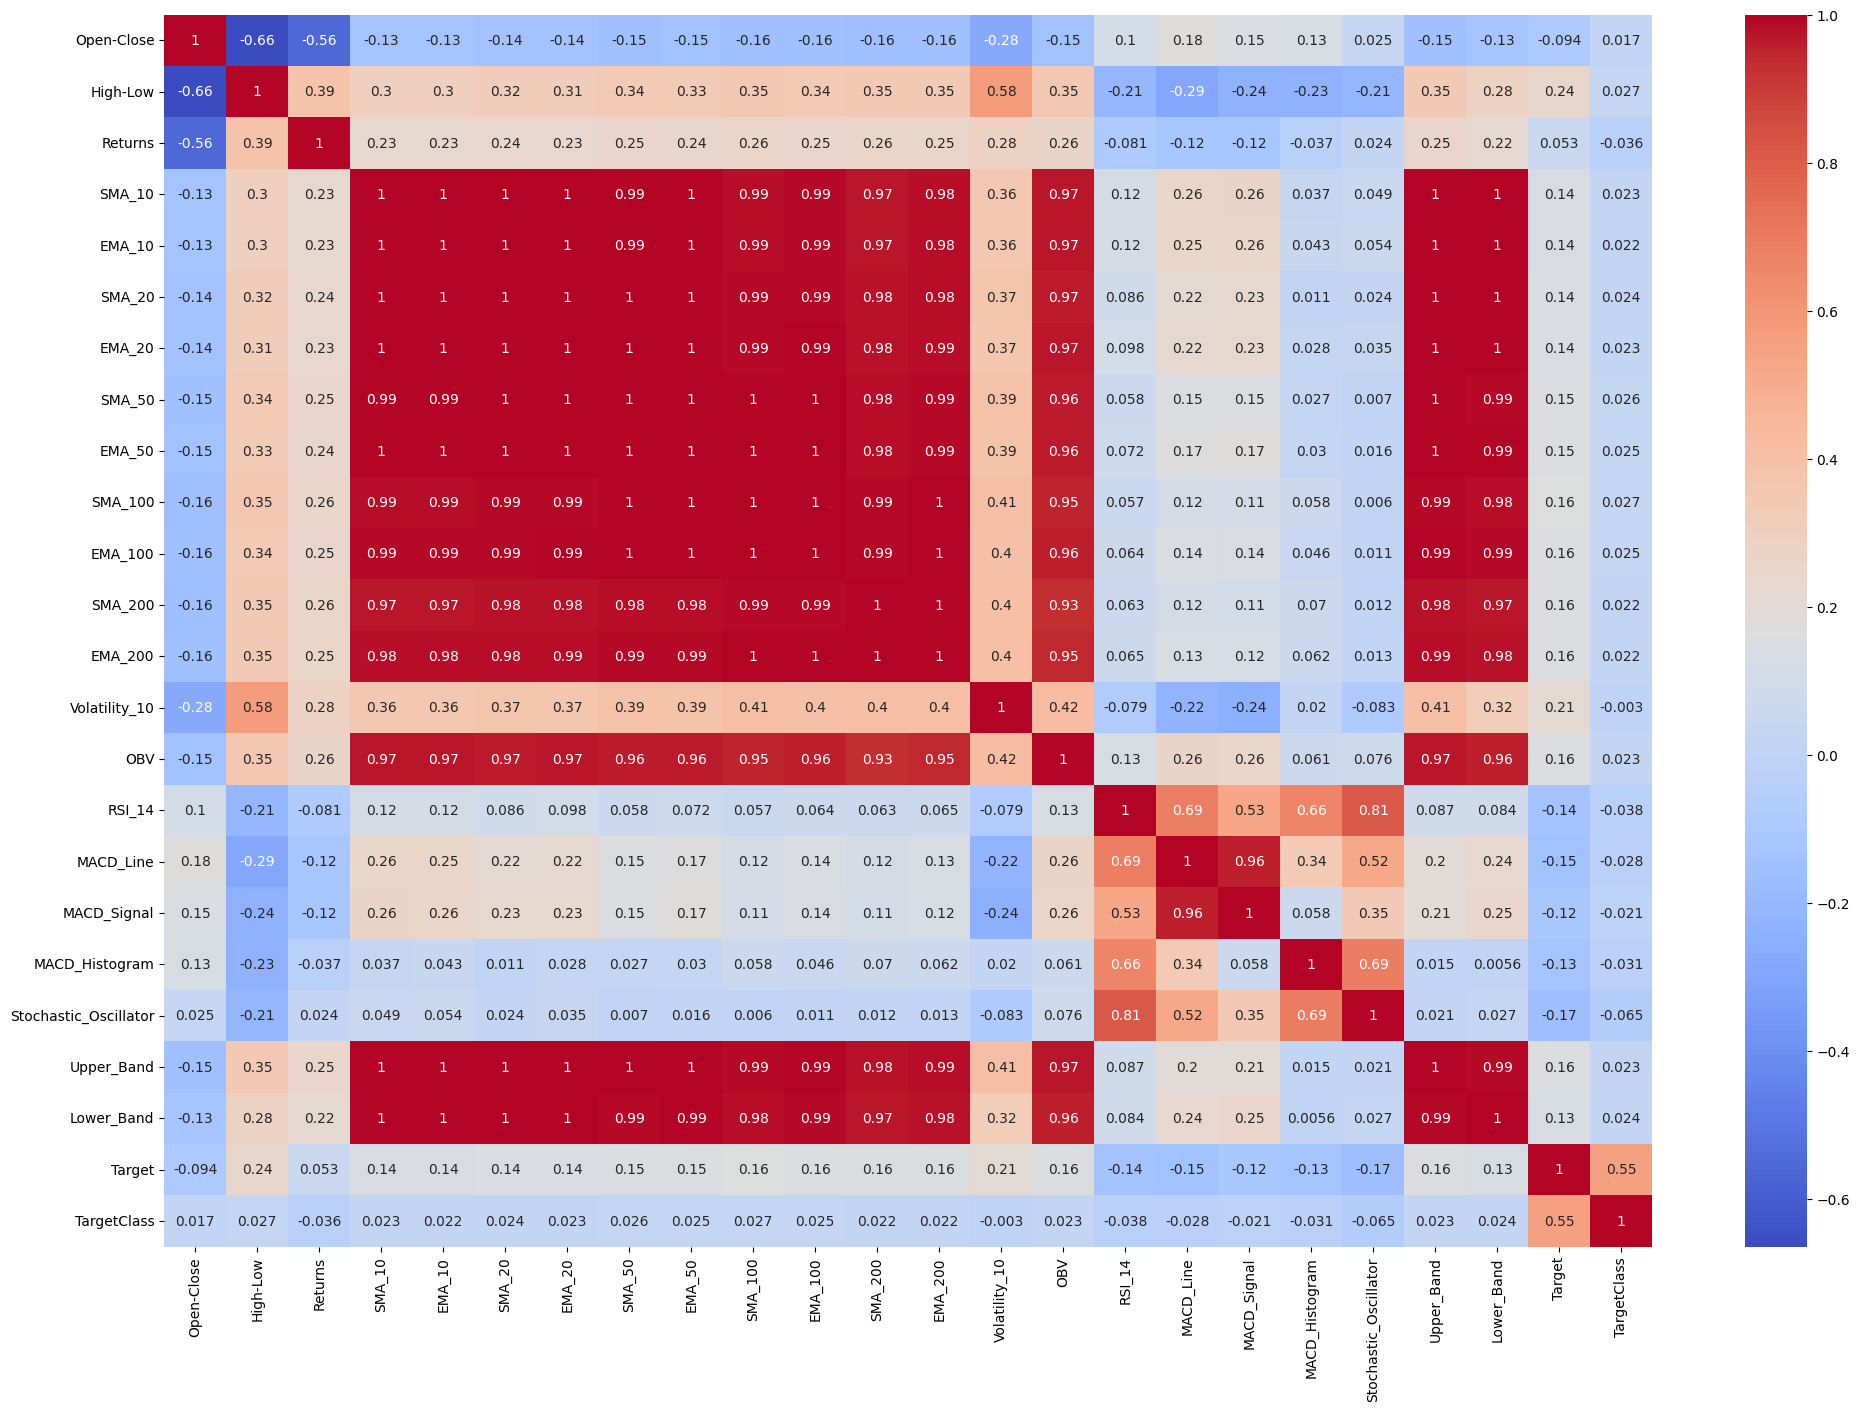

Index(['Open-Close', 'High-Low', 'Returns', 'SMA_10', 'EMA_10', 'SMA_20',
       'EMA_20', 'SMA_50', 'EMA_50', 'SMA_100', 'EMA_100', 'SMA_200',
       'EMA_200', 'Volatility_10', 'OBV', 'RSI_14', 'MACD_Line', 'MACD_Signal',
       'MACD_Histogram', 'Stochastic_Oscillator', 'Upper_Band', 'Lower_Band'],
      dtype='object')


<ipython-input-51-070a4a38ad3c>:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = pd.DataFrame(X_train).fillna(method='ffill').fillna(method='bfill').values # Fill NaN values using forward and backward fill in training set
<ipython-input-51-070a4a38ad3c>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = pd.DataFrame(X_test).fillna(method='ffill').fillna(method='bfill').values # Fill NaN values using forward and backward fill in test set
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentat

Epoch 1/10
32/32 [==============================] - 1s 5ms/step - loss: 3.5279 - accuracy: 0.7687
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 3.5279 - accuracy: 0.7687
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 3.5279 - accuracy: 0.7687
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 3.5279 - accuracy: 0.7687
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 3.5279 - accuracy: 0.7687
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 3.5279 - accuracy: 0.7687
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 3.5279 - accuracy: 0.7687
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 3.5279 - accuracy: 0.7687
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 3.5279 - accuracy: 0.7687
Epoch 10/10
8/8 [==============================] - 0s 6ms/step


<ipython-input-44-41b3583e7496>:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_stats = pd.concat([df_stats, pd.DataFrame({'Model': model, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC AUC Score': roc_auc}, index=[0])], ignore_index=True)


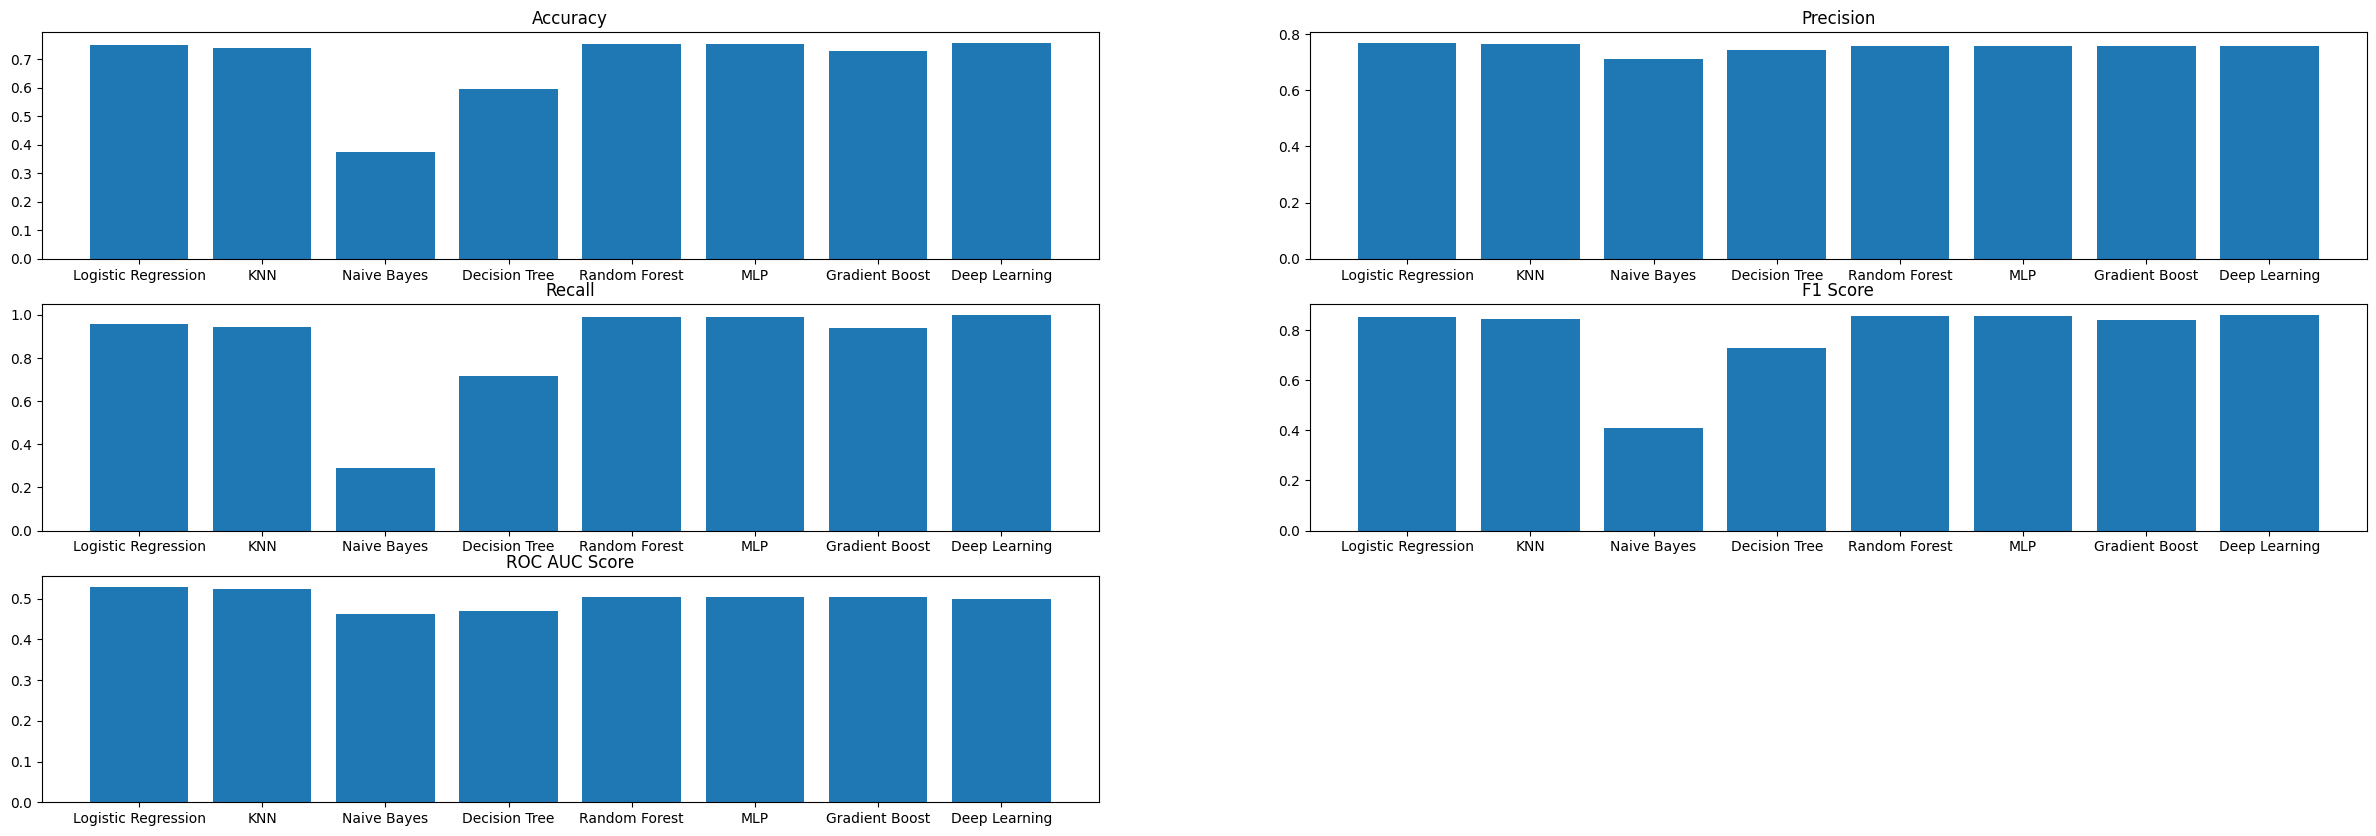

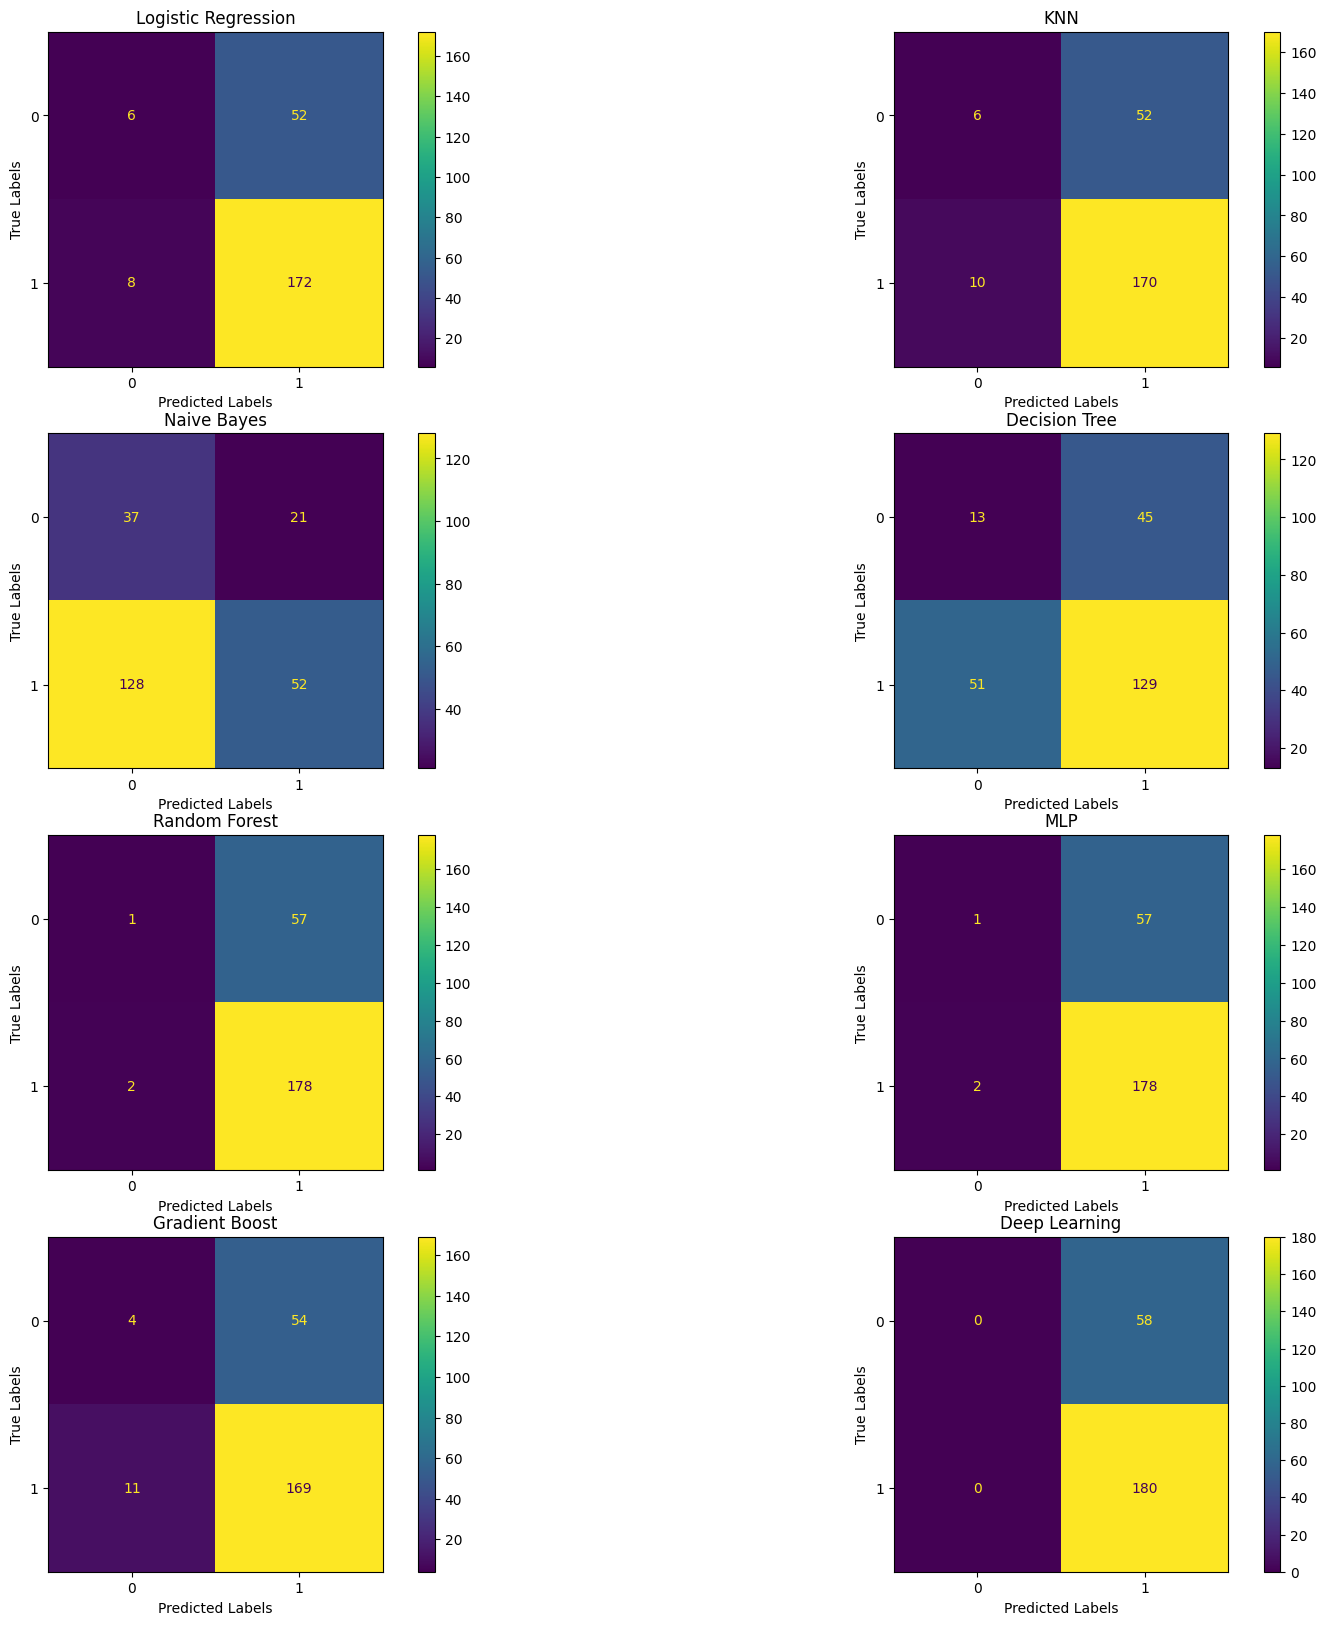

In [ ]:
main("^NSEI", "2014-01-01", "2024-01-01")